In [7]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mlflow
import warnings
warnings.filterwarnings('ignore')
from typing import Dict, List, Any

In [8]:
# setup mlflow for tracking
mlflow_setup = {
    'EXPERIMENT_NAME' : "Car_Price_Prediction_EDA",
    'TRACKING_URI' : "sqlite:///car_price_prediction_EDA"
}

mlflow.set_tracking_uri(mlflow_setup['TRACKING_URI'])
mlflow.set_experiment(mlflow_setup['EXPERIMENT_NAME'])

<Experiment: artifact_location='file:c:/Users/Maxwe/ML Projects/Car-Price-Prediction-Model/notebooks/mlruns/1', creation_time=1768049801917, experiment_id='1', last_update_time=1768049801917, lifecycle_stage='active', name='Car_Price_Prediction_EDA', tags={}>

# `Step 1: Load Data`

In [9]:
#read the csv file into the python environment as a pandas dataFrame
def _load_data(data_source: str | Path = "../data/raw/car_details.csv") -> pd.DataFrame:
    """ 
        Loads the data from csv file into the jupyter environment as a pandas dataframe

        Args:
            data_source: str|Path = Path to csv file

        Returns:
            pd.DataFrame containing rows and columns

        Raises:
            FileNotFoundError: If file path is not found
            ValueError: If dataframe is empty
    """
    filepath = Path(data_source)
    if not filepath.exists():
        raise FileNotFoundError(f'File Not Found! Check filepath and try again')
    
    try:
        print(f'Reading Data From CSV File...')
        df = pd.read_csv(data_source) 
        print(f'Data successfully loaded with {len(df)} rows and {len(df.columns)} columns')

        # log dataset and its relevant info in mlflow
        dataset = mlflow.data.from_pandas(
            df, filepath, name='car_price_details',targets="selling_price"
        )

        # log shape of dataset
        mlflow.log_params({
        'n_rows' : len(df),
        'n_columns' : len(df.columns)
        })
        
        return df
    except Exception as e:
        print(f'An error was encountered whiles trying to read data from CSV file : {e}')
        raise


In [10]:
df = _load_data()

Reading Data From CSV File...
Data successfully loaded with 8128 rows and 13 columns


# `Summary Stats of Numeric Columns`

In [13]:
def numeric_summary_stats(df: pd.DataFrame, output_file: str | Path) -> None:
    """
        Short descriptive summary statistics of numeric columns
        in the dataset and saves the results in a json file for
        persistance and traceability,

        Args: 
            df: pd.DataFrame
            output_file: File path to save json data
        
        Example:
            numeric_summary_stats(df,"results/numeric_summary.json")
    """
    try:
        df.describe().to_json(output_file, indent=4)
        print(f'Numeric descriptive stats saved to {output_file}')

        mlflow.log_artifact(output_file)
    except Exception as e:
        print(f'An error occured whiles trying to save json data : {e}')
        raise

In [14]:
def categorical_summary_data(df: pd.DataFrame, output_file: str | Path) -> None:
    """  
        Short descriptive summary statistcis of categorical columns
        in the dataset and saves the result in a json file for
        persistence and traceability

        Args:
            df: pd.DataFrame
            output_file = File path to save json data
    """
    try:
        df.describe(exclude=[np.number]).to_json(output_file, indent=4)
        print(f'Categorical descriptive stats saved to {output_file}')

        mlflow.log_artifact(output_file)
    except Exception as e:
        print(f'An error occured whiles trying to save json data : {e}')
        raise

In [15]:
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
cols = [col for col in categorical_cols] #a list comprehension, making a list of categorical columns
print(f'This dataset has {len(cols)} categorical columns - {cols}') #returns the number of categorical columns

This dataset has 6 categorical columns - ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'torque']


In [16]:
for col in categorical_cols: #loop through categorical columns
    print(f' - {col:<15} | Unique: {df[col].nunique():<3} | Examples:  {df[col].unique()[:3]}') #returns column names, unique values and number of unique values

 - name            | Unique: 2058 | Examples:  ['Volvo XC90 T8 Excellence BSIV' 'Mercedes-Benz S-Class S 350 CDI'
 'Jeep Wrangler 2016-2019 3.6 4X4']
 - fuel            | Unique: 4   | Examples:  ['Petrol' 'Diesel' 'CNG']
 - seller_type     | Unique: 3   | Examples:  ['Individual' 'Dealer' 'Trustmark Dealer']
 - transmission    | Unique: 2   | Examples:  ['Automatic' 'Manual']
 - owner           | Unique: 5   | Examples:  ['First Owner' 'Third Owner' 'Second Owner']
 - torque          | Unique: 441 | Examples:  ['640Nm@ 1740rpm' '490Nm@ 1600rpm' '347Nm@ 4300rpm']


In [17]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols = [col for col in numerical_cols] # a list comprehension, creating a list of numerical columns
print(f'This dataset has {len(cols)} numerical columns - {cols}') #returns the number of numerical columns

This dataset has 7 numerical columns - ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']


In [18]:
for cols in numerical_cols: #loops through columns
    print(f'- {cols:<14}   - Min value: {df[cols].min():<12}   - Max value: {df[cols].max()}') #returns column name, minimum value and maximum value

- year             - Min value: 1983           - Max value: 2020
- selling_price    - Min value: 29999          - Max value: 10000000
- km_driven        - Min value: 1              - Max value: 2360457
- mileage          - Min value: 0.0            - Max value: 42.0
- engine           - Min value: 624.0          - Max value: 3604.0
- max_power        - Min value: 0.0            - Max value: 400.0
- seats            - Min value: 2.0            - Max value: 14.0


Definition of Columns
- name - The model name of the car
- fuel - The type of fuel used
- seller type - Who's selling the car
- transmission - The gear system of the car
- owner - Ownership history
- torque - rotational force of the engine
- year - The manufacturing year of the car
- selling_price - The selling price of the car
- km_driven - The number of kilometres the car has been driven
- mileage - the efficiency of the fuel
- engine - engine displacement
- max_power - maximum power output of the engine
- seats - number of seats available in the car

# `DATA QUALITY CHECKS`

In [ ]:
#checking for duplicated data, keeping the first occurence
n_duplicates = df.duplicated(keep='first').sum() #returns duplicated rows, keeping only the first occurence

# `VISUALIZATIONS`

In [20]:
# +1: strong positive correlation (as one increases, the other increases)
# -1: strong negative correlation (as one increases, the other decreases)
# 0: no correlation
def plot_correlation_heatmap(df, method: str = 'spearman', plot_dir: str | Path = '../plots/'):
    """  
    This function visualizes the relationship between numerical columns
    through a correlation heatmap

    Args:
        method : whether to use a pearson or spearman method for correlation
        plots_dir : file path to which plot will be saved

    Raises:
        An expection when an error is encountered during plotting and saving the plot
    """
    numeri
    corr = df.corr(method='spearman',numeric_only=True) #calculates correlation of numeric data using the spearman method
    #plotting correlation using a heatmap
    plt.rcParams['figure.figsize'] = (15,10)
    sns.heatmap(data=corr,annot=True,linewidths=1,fmt='.2f')
    plt.title('Correlation HeatMap of Numeric Features',fontsize = 20)
    plt.show()
    output_dir = plot_dir / 'heatmap.png'
    plt.savefig(output_dir, dpi=300, bbox_inches="tight")
    plt.close()

    mlflow.log_artifact(output_dir)

In [21]:
#checking for missing data
missing = df.isnull().sum().sort_values(ascending=False) #sums all null values for each columns
missing_pct = missing / len(df) * 100 #calculates missing values as a percentage of rows in the data
missing_df = pd.DataFrame({
    'missing values' :missing,
    'Missing Pct': missing_pct
})
print(missing_df) #returns missing values and missing percentages as a dataframe

               missing values  Missing Pct
torque                    222     2.731299
seats                     221     2.718996
engine                    221     2.718996
mileage                   221     2.718996
max_power                 216     2.657480
fuel                        0     0.000000
km_driven                   0     0.000000
selling_price               0     0.000000
year                        0     0.000000
name                        0     0.000000
owner                       0     0.000000
seller_type                 0     0.000000
transmission                0     0.000000


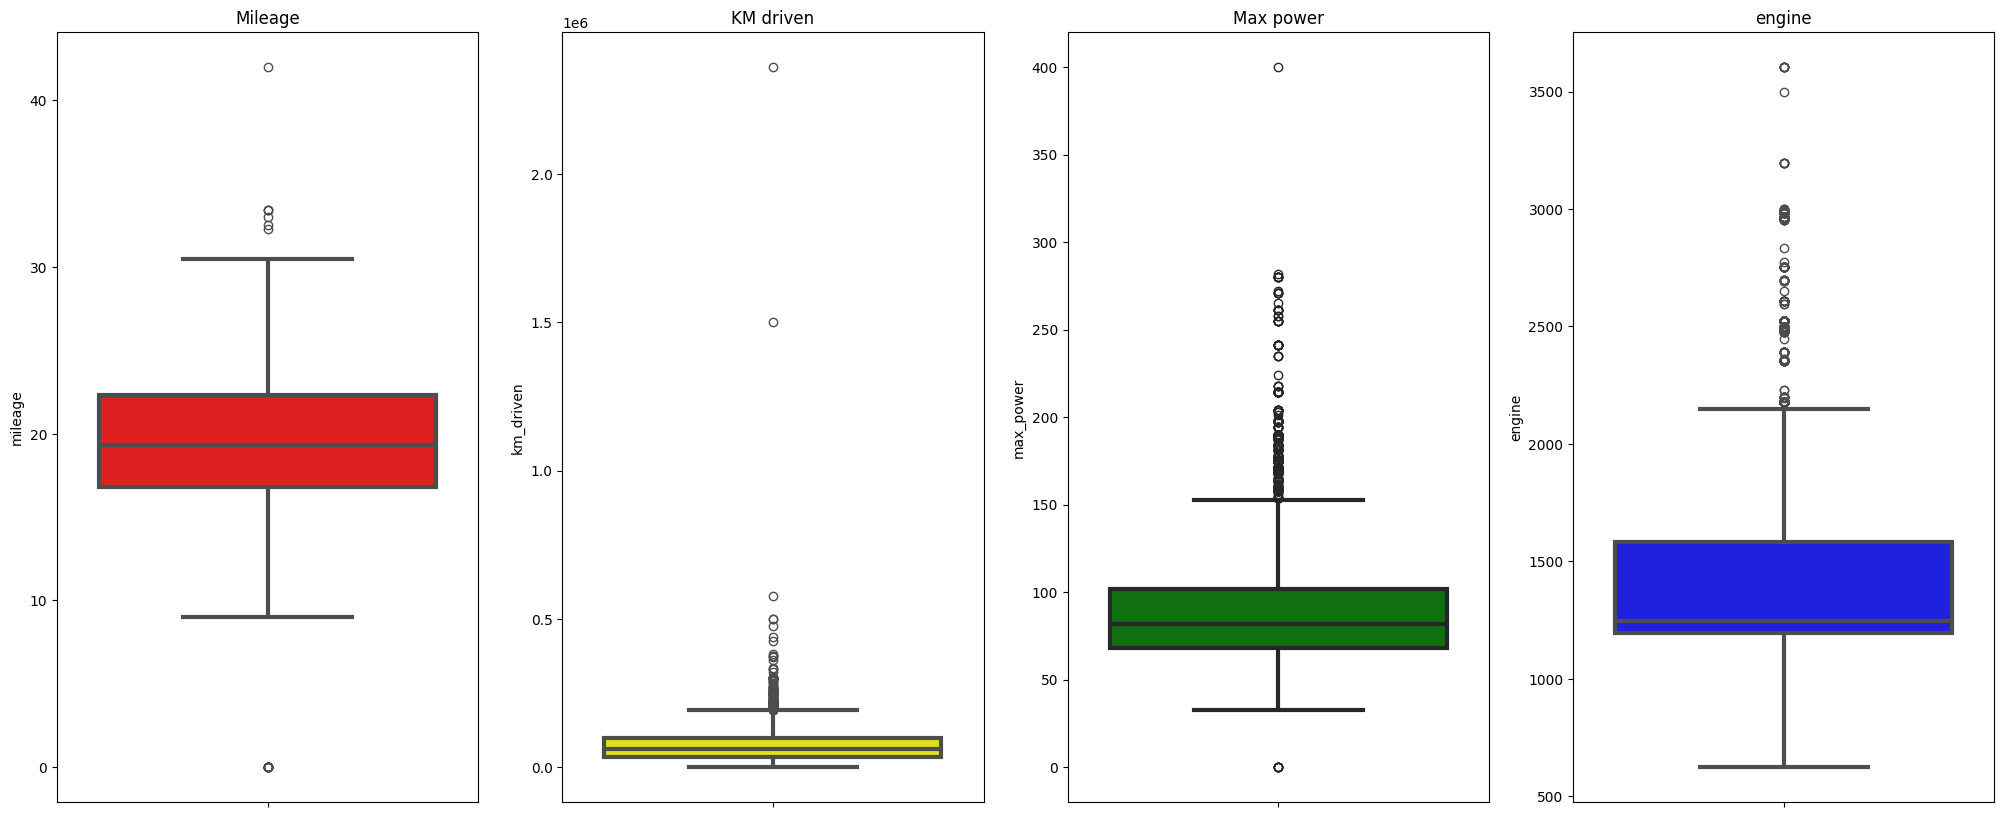

In [22]:
#plotting boxplots to reveal outliers
plt.subplots(1,4,figsize=(25,10))
plt.subplot(141)
sns.boxplot(data=df,y='mileage',color='red',linewidth=3)
plt.title('Mileage')

plt.subplot(142)
sns.boxplot(data=df,y='km_driven',color='yellow',linewidth=3)
plt.title('KM driven')

plt.subplot(143)
sns.boxplot(data=df,y='max_power',color='green',linewidth=3)
plt.title('Max power')

plt.subplot(144)
sns.boxplot(data=df,y='engine',color='blue',linewidth=3)
plt.title('engine')
plt.show()


KeyboardInterrupt: 

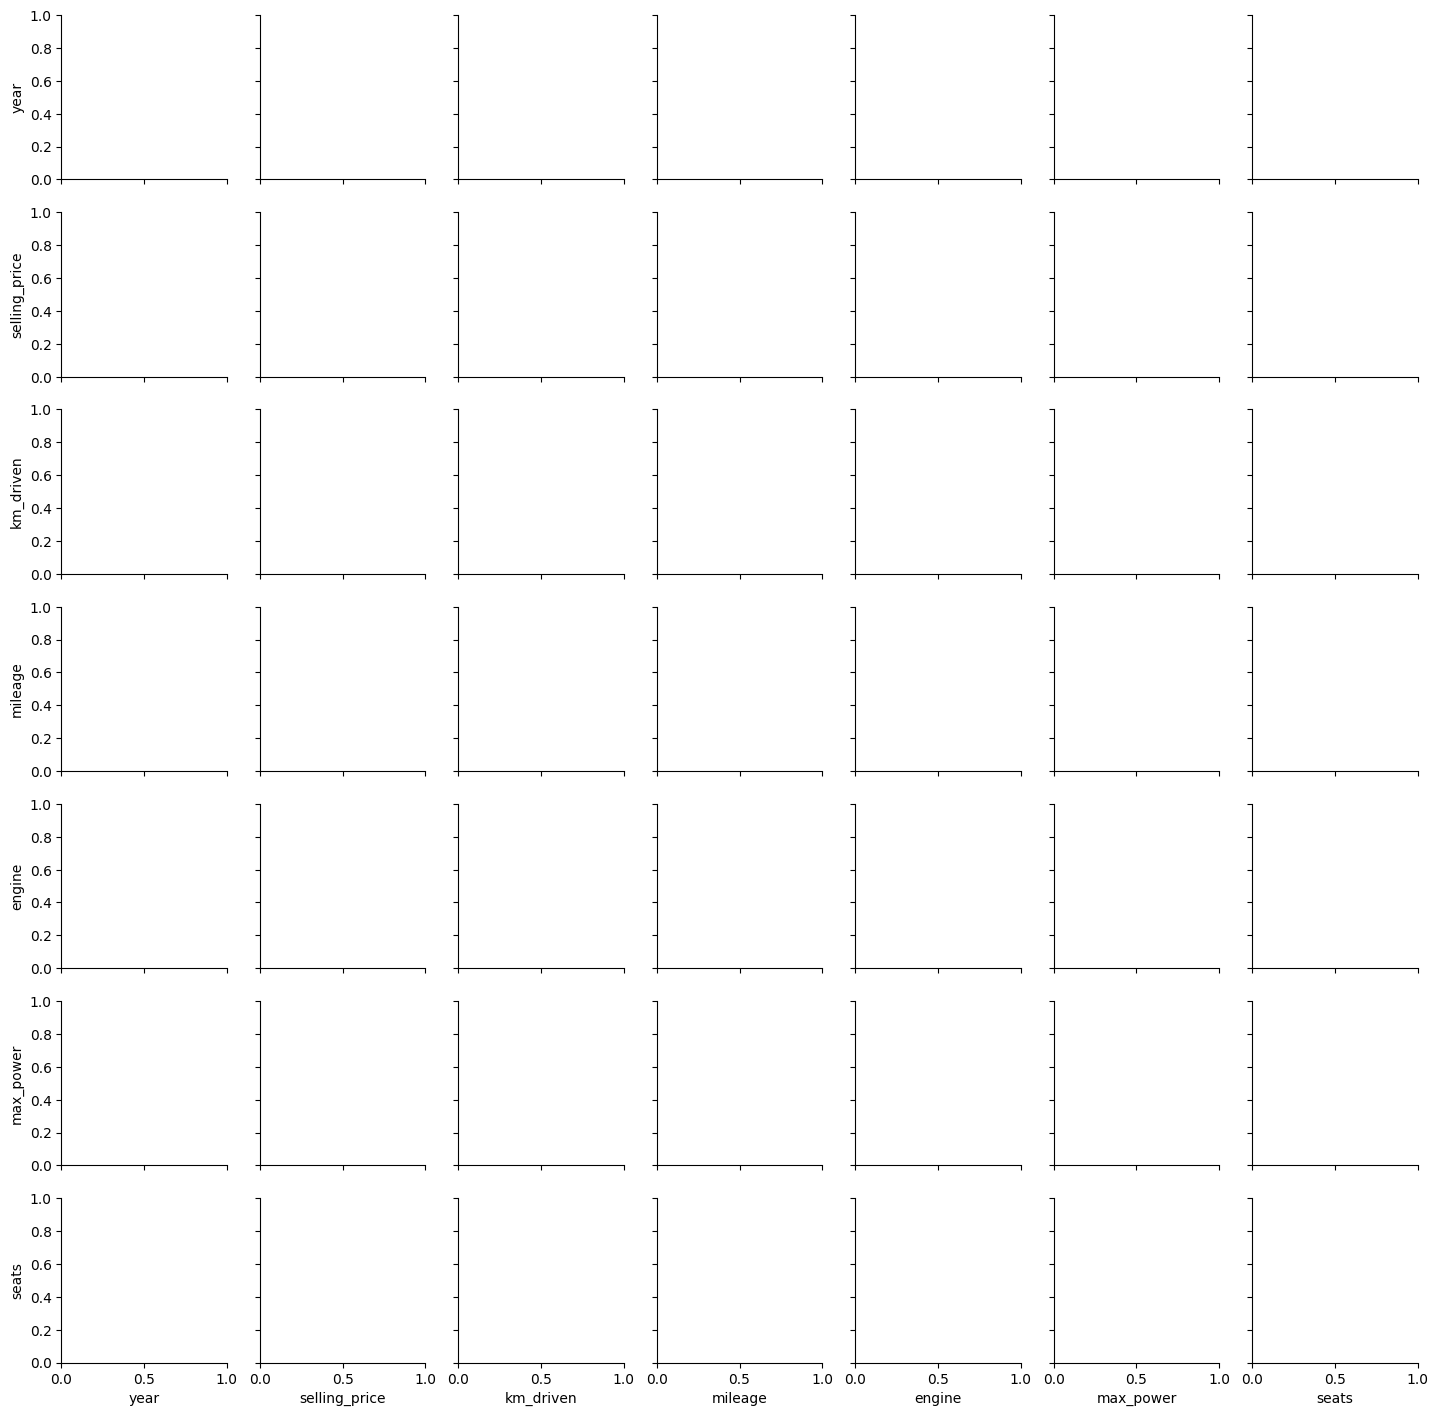

In [23]:
#plotting pariplots to reveal relationships
sns.pairplot(data=df) 

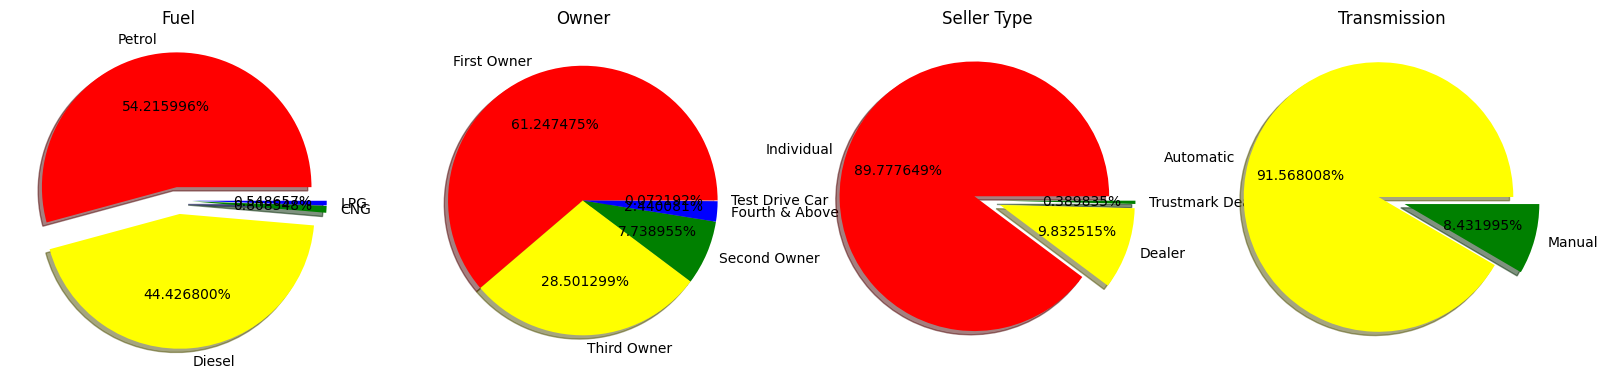

In [ ]:
#performing analysis on categorical data
plt.rcParams['figure.figsize'] =(20,10)
plt.subplot(1,4,1)
size = df['fuel'].value_counts() #counts all the values in the column
labels = df['fuel'].unique() #returns unique values in the column
colors = ['red','yellow','green','blue']
plt.title('Fuel')
plt.pie(size,labels=labels,colors=colors, autopct='%2f%%',shadow=True,explode=[0.1,0.1,0.1,0.1]) #plotting a pie chart

plt.subplot(1,4,2)
size = df['owner'].value_counts()
labels = df['owner'].unique()
colors = ['red','yellow','green','blue','pink']
plt.title('Owner')
plt.pie(size,labels=labels,colors=colors, autopct='%2f%%',shadow=True)

plt.subplot(1,4,3)
size = df['seller_type'].value_counts()
labels = df['seller_type'].unique()
colors = ['red','yellow','green','blue']
plt.title('Seller Type')
plt.pie(size,labels=labels,colors=colors, autopct='%2f%%',shadow=True,explode=[0.1,0.1,0.1])

plt.subplot(1,4,4)
size = df['transmission'].value_counts()
labels = df['transmission'].unique()
colors = ['yellow','green','blue']
plt.title('Transmission')
plt.pie(size,labels=labels,colors=colors, autopct='%2f%%',shadow=True,explode=[0.1,0.1])
plt.show()

In [ ]:
#analyzing the target output
print(df['selling_price'].skew())

5.572742292649191


In [ ]:
#transforming target column to handle skewness
df['selling_price_scaled'] = np.log1p(df['selling_price'])

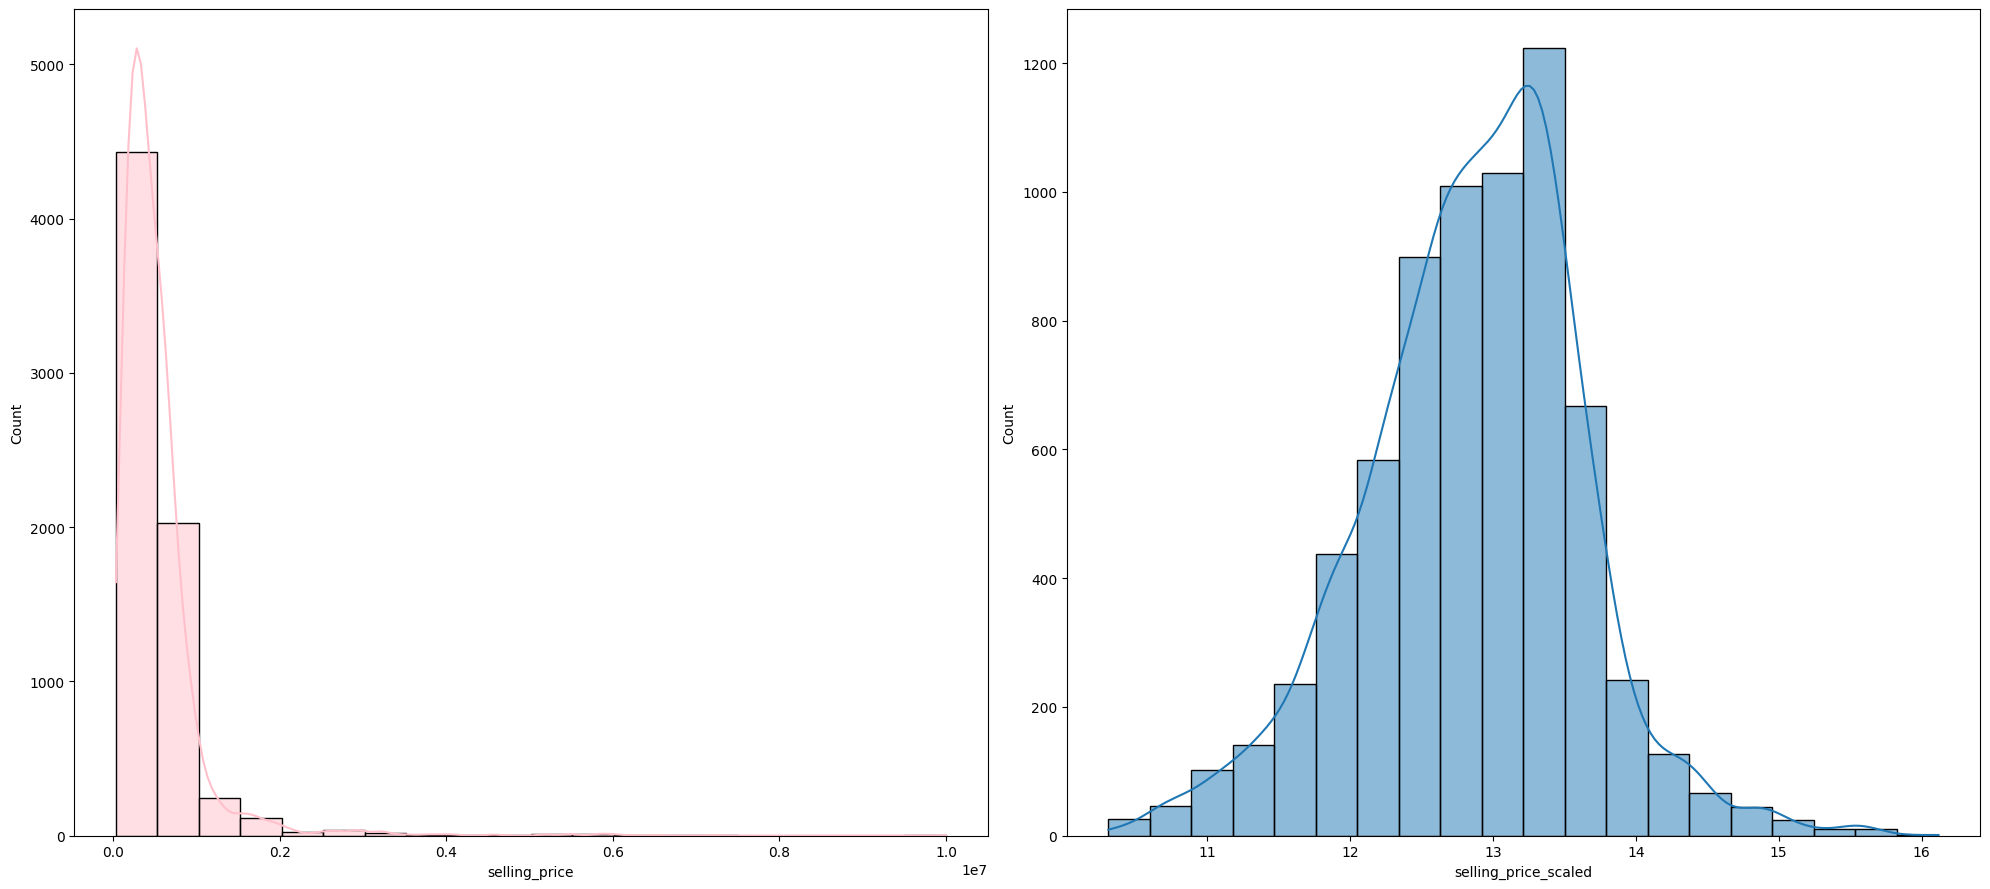

In [ ]:
#plotting target output, before and after log-transformations
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
sns.histplot(df['selling_price'],kde=True,bins=20,color='pink')

plt.subplot(1,2,2)
sns.histplot(df['selling_price_scaled'],kde=True,bins=20)
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('data/processed_df.csv')